# Проект: Маркетинг. Предсказание вероятности покупки

## О проекте

__Описание задачи:__

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

__Цель проекта__:

- Разработать модель машинного обучения для выявления пользователей, готовых совершить покупку в интернет-магазине.

__Описание данных__:

● __apparel-purchases__

_Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']._

* client_id - идентификатор клиента
* quantity - количество единиц товара
* price - цена товара
* category_ids - идентификаторы категорий
* date - дата покупки
* message_id - идентификатор сообщения из рассылки

● apparel-messages

_Рассылки, которые были отправлены клиентам из таблицы покупок._
* bulk_campaign_id - идентификатор рассылки
* client_id - идентификатор клиента
* message_id - идентификатор сообщения
* event - действие с сообщением (отправлено, открыто, покупка…)
* channel - канал рассылки
* date - дата действия
* created_at - дата-время полностью

● target
* client_id - идентификатор клиента
* target - клиент совершил покупку в целевом периоде

__Дополнительно__:

Агрегированная по дням статистика по рассылкам. Если создавать на основе этой статистики дополнительные признаки, нельзя суммировать по колонкам nunique, потому что это уникальные клиенты в пределах дня, и нет данных, повторяются ли они в другие дни.

● full_campaign_daily_event
Агрегация общей базы рассылок по дням и типам событий. В именах колонок есть все типы событий event.
* date - дата
* bulk_campaign_id - идентификатор рассылки
* count_event* - общее количество каждого события event
* nunique_event* - количество уникальных client_id в каждом событии

● full_campaign_daily_event_channel
Агрегация по дням с учетом событий и каналов рассылки. В именах колонок есть все типы событий event и каналов рассылки channel.
* date - дата
* bulk_campaign_id - идентификатор рассылки
* count_event*_channel* - общее количество каждого события по каналам
* nunique_event*_channel* - количество уникальных client_id по событиям и каналам

__План работы__:
- изучить данные
- разработать полезные признаки
- создать модель для классификации пользователей
- улучшить модель и максимизировать метрику roc_auc
- выполнить тестирование

__Метрика__: ROC-AUC (не меньше 0.7)

## Подготовка к проекту

### Установка библиотек

In [123]:
!pip install -q phik

In [124]:
!pip install -q catboost

In [125]:
!pip install -q shap

### Импортирование библиотек и функций

In [126]:
import time
import warnings

import numpy as np
import pandas as pd
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score,  \
 confusion_matrix, precision_score, recall_score, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, \
 OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import shap

### Объявление констант

In [127]:
TITLE_SIZE = 18
LABEL_SIZE = 16
TEST_SIZE = 0.25
RANDOM_STATE = 42

### Прочие настройки

In [128]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [129]:
! gdown --id 1bCuf_zuRW8fs9vLF5pClZSbV1ZK2hi9i

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bCuf_zuRW8fs9vLF5pClZSbV1ZK2hi9i
From (redirected): https://drive.google.com/uc?id=1bCuf_zuRW8fs9vLF5pClZSbV1ZK2hi9i&confirm=t&uuid=5084a653-b087-4ad3-900f-7b77c07b1ee9
To: /content/apparel-messages.csv
100% 1.41G/1.41G [00:27<00:00, 51.0MB/s]


In [130]:
! gdown --id 1LqhvioMUnFJj_riMnics5rDTBjgKCDg-

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1LqhvioMUnFJj_riMnics5rDTBjgKCDg-
To: /content/apparel-purchases.csv
100% 21.8M/21.8M [00:00<00:00, 33.9MB/s]


In [131]:
! gdown --id 1icH7TcxtRVVGIqkzJ-2GOQYBZdsIc5kg

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1icH7TcxtRVVGIqkzJ-2GOQYBZdsIc5kg
To: /content/apparel-target_binary.csv
100% 1.10M/1.10M [00:00<00:00, 18.1MB/s]


In [132]:
! gdown --id 1CLzeWJUBBl_Jaq-_wItBvHxkBm97zUuj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CLzeWJUBBl_Jaq-_wItBvHxkBm97zUuj
To: /content/full_campaign_daily_event_channel.csv
100% 11.3M/11.3M [00:00<00:00, 33.6MB/s]


In [133]:
! gdown --id 1EOFZ3LUtS0W1uza9KDLKkcJBHBJVBKgU

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EOFZ3LUtS0W1uza9KDLKkcJBHBJVBKgU
To: /content/full_campaign_daily_event.csv
100% 8.19M/8.19M [00:00<00:00, 80.2MB/s]


## Обзор данных

In [134]:
def show_info(df):
    """
    Функция выводит на экран информацию о датафрейме,
    первые 5 строк датафрейма и количество пропущенных значений
    для каждого столбца.

    Args:
        df (DataFrame) - Датафрейм.
    Returns:
        None
    """
    display(df.head())
    df.info()
    print("Пропущенные значения:")
    display(df.isna().sum())

### messages

In [135]:
messages = pd.read_csv('/content/apparel-messages.csv',
        parse_dates=['date', 'created_at'])
show_info(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
Пропущенные значения:


,0
bulk_campaign_id,0
client_id,0
message_id,0
event,0
channel,0
date,0
created_at,0


### purchases

In [136]:
purchases = pd.read_csv('/content/apparel-purchases.csv',
        parse_dates=['date'])
show_info(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
Пропущенные значения:


,0
client_id,0
quantity,0
price,0
category_ids,0
date,0
message_id,0


### target_binary

In [137]:
target_binary = pd.read_csv('/content/apparel-target_binary.csv')
show_info(target_binary)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
Пропущенные значения:


,0
client_id,0
target,0


### fc_daily_event

In [138]:
fc_daily_event = pd.read_csv('/content/full_campaign_daily_event.csv',
        parse_dates=['date'])
show_info(fc_daily_event)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

,0
date,0
bulk_campaign_id,0
count_click,0
count_complain,0
count_hard_bounce,0
count_open,0
count_purchase,0
count_send,0
count_soft_bounce,0
count_subscribe,0


### fc_daily_event_channel

In [139]:
fc_daily_event_channel = pd.read_csv('/content/full_campaign_daily_event_channel.csv',
        parse_dates=['date'])
show_info(fc_daily_event_channel)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

,0
date,0
bulk_campaign_id,0
count_click_email,0
count_click_mobile_push,0
count_open_email,0
count_open_mobile_push,0
count_purchase_email,0
count_purchase_mobile_push,0
count_soft_bounce_email,0
count_subscribe_email,0


__Промежуточный вывод__:
Мы запгрузили и изучили датасеты:
- purchases - 202 208 записей,
- messages  - 12 739 798 записей,
- target_binary - 49 849 записей,
- fc_daily_event - 13 1072 записей,
- fc_daily_event_channel - 131 072 записей.

Все данные соответствуют описанию, пропусков нет, имена столбцов записаны в змеином регистре.

Из названий столбцов full_campaign_daily_event_channel определили все возможные типы событий event и каналы рассылки.

Типы событий:
- click
- complain
- hard_bounce
- open
- purchase
- send
- soft_bounce
- subscribe
- unsubscribe
- hbq_spam
- close


Каналы рассылки:
- email
- mobile_push

## Предобработка данных

Создадим копии датасетов для контроля изменения размерности после предобработки и очистки.

In [140]:
check_purchases = purchases.copy()
check_messages = messages.copy()
check_target_binary = target_binary.copy()

### Дубликаты

In [141]:
for df in [purchases, messages, target_binary, fc_daily_event, fc_daily_event_channel]:
    print(df.duplicated().sum())

73020
48610
0
0
0


Дубликаты есть в двух датасетах: `messages` и `purchases`.

Дубликаты в датасете `messages` удаляем, т.к. он содержит столбец `created_at` - точное время создания сообщения. Дубликаты в `purchases` нужно сохранить, т.к. известна только дата покупки. Клиенты могли совершить такую же покупку в течение одного дня. Также отметим, что 99.6% записей содержат информацию о покупке 1 единицы товаров, возможно, существуют  особенности сохранения данных о покупках в базе данных маркетплейса (создание отдельной записи для каждой единицы товара). Значения, не равные 1, могут отображать покупку товара, который продается только упаковками (по несколько штук).

In [142]:
messages = messages.drop_duplicates().reset_index(drop=True)

In [143]:
messages.shape[0], messages.shape[0] / check_messages.shape[0]

(12691188, 0.9961843979001865)

Проверим, нет ли неявных дубликатов в target_binary.

In [144]:
target_binary.duplicated('client_id').sum()

0

### Проверка уникальных значений категорий

Посмотрим, если ошибки в значениях 'channel' и 'event' в messages.

In [145]:
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [146]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

С этими уникальными значениями все в порядке, соответствуют информации, полученной из названий колонок full_campaign_daily_event_channel.

### Проверка соответствия выборок

Будем отталкиваться от датасета target_binary, а именно от client_id. Проверим, по всем ли клиентам есть данные в датасетах purchases и messages.

In [147]:
set(target_binary['client_id']) == set(purchases['client_id'])

True

In [148]:
set(target_binary['client_id']) == set(messages['client_id'])

False

In [149]:
target_binary['client_id'].nunique(), messages['client_id'].nunique()

(49849, 53329)

In [150]:
if set(target_binary['client_id']).issubset(set(messages['client_id'])):
    print("Все client_id из target_binary входят в messages.")
else:
    print("Не все client_id из target_binary входят в messages.")
    print(f"Отсутствуют {len(set(target_binary['client_id']) - set(messages['client_id']))} client_id.")

Не все client_id из target_binary входят в messages.
Отсутствуют 7867 client_id.


В датасете messages есть клиенты, которых нет в датасете target_binary (число уникальных `client_id` в `messages` - 53329, в `target_binary` - 49849). Не все `client_id` из датасета `target_binary` есть в датасете `messages` (нет данных о сообщениях для 7867 клиентов). Очистим датасет `messages` от не интересующих нас записей.


In [151]:
messages = messages[messages['client_id'].isin(target_binary['client_id'])]

In [152]:
# контроль изменения размерности
messages.shape[0], messages.shape[0] / check_messages.shape[0]

(10913197, 0.8566224519415457)

__Промежуточный вывод__:
- удалили 48 610 дубликатов из `messages`, потеряли 0.4% данных,
- обнаружили дубликаты в `purchases` (73 020), но сохранили их, т.к. это  могут быть записи о разных покупках, совершенных в течение одного дня,
- удалили информацию из `messages` по клиентам, которых нет в `target_binary`, итоговый размер составляет 10 913 197 записей. Потеря составляет 14% данных, однако это были дубликаты и данные, не несущие ценности в рамках данной задачи.

## Исследовательский анализ данных

In [153]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных
     признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха

    Args:
        data (pd.DataFrame): Датасет.
        column (str): Колонка для анализа.
        title (str): Заголовок для вывода графика.
        bins_number (int, optional): Количество интервалов для гистограммы.

    Returns:
        None
    """

    median = data[column].median()
    mean = data[column].mean()

    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)

    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5,
                  label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"',
                    fontsize=TITLE_SIZE)

    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [154]:
def analyze_discrete_data(data, column, title):
    """
    Функция помогает при проведении статистического анализа дискретных численных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.

    Выводит для колонки:
    - описание данных
    - график частот
    - диаграмму размаха

    Args:
        data (pd.DataFrame): Датасет.
        column (str): Колонка для анализа.
        title (str): Заголовок для вывода графика.

    Returns:
        None
    """

    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())

    # Создаем фигуру и оси
    fig, ax = plt.subplots(2, 1, figsize=(17, 12))

    # График частот
    sns.countplot(x=data[column], ax=ax[0], palette='coolwarm', hue=data[column], legend=False)
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(False)
    # Добавление значений на столбцах
    for p in ax[0].patches:
        ax[0].annotate(f'{p.get_height():.0f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       fontsize=12, color='black',
                       xytext=(0, 5), textcoords='offset points')

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

### target

In [155]:
target_binary['target'].value_counts(normalize=True)

,proportion
target,
0,0.980722
1,0.019278


In [156]:
grouped_data = (
    target_binary
    .groupby('target')
    .agg(
        count=('client_id', 'count'),
        percent=('client_id', lambda x: 100 * x.size / target_binary.shape[0])
    )
)
grouped_data

,count,percent
target,,
0,48888,98.072178
1,961,1.927822


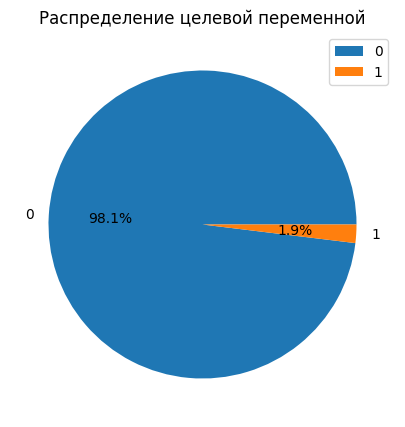

In [157]:
grouped_data['count'].plot.pie(
    figsize=(10, 5),
    autopct='%1.1f%%',
    legend=True,
    title='Распределение целевой переменной').set_ylabel("");

In [158]:
target_binary['client_id'].nunique()

49849

Наблюдаем сильный дисбаланс классов: только 1.9% пользователей из выборки совершили покупку. Повторяющихся значений `client_id` нет.


### purchases

In [159]:
purchases.shape[0]

202208

In [160]:
purchases.nunique()

,0
client_id,49849
quantity,16
price,3642
category_ids,933
date,642
message_id,50204


In [161]:
purchases.groupby('client_id').agg(count=('quantity', 'count')).sort_values(by='count', ascending=False)

,count
client_id,
1515915625853312319,346
1515915625624308268,218
1515915625607113301,210
1515915625470860261,131
1515915625500232103,131
...,...
1515915625582346529,1
1515915625488623100,1
1515915625488623203,1


Всего в 202 208 записях содержатся данные о покупках 49 849 клиентов. У каждого было от 1 до 346 покупок. На данном этапе будем просто анализировать purchases, не удаляя нетипичные значения, т.к. можем потерять всю информацию по клиенту.

In [162]:
purchases['date'].min(), purchases['date'].max()

(Timestamp('2022-05-16 00:00:00'), Timestamp('2024-02-16 00:00:00'))

Датасет содержит сведения о покупках с 16.05.2022 по 16.02.2024. Примем за дату выгрузки день, следующий за максимальной датой. Будем использовать эту дату при создании признака, отражающего, как давно клиент совершил последнюю покупку.

In [163]:
date_of_unloading = purchases['date'].max() + pd.Timedelta(days=1)
date_of_unloading

Timestamp('2024-02-17 00:00:00')

Количество товаров в заказе


,quantity
count,202208.000000
mean,1.006483
std,0.184384
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,30.000000


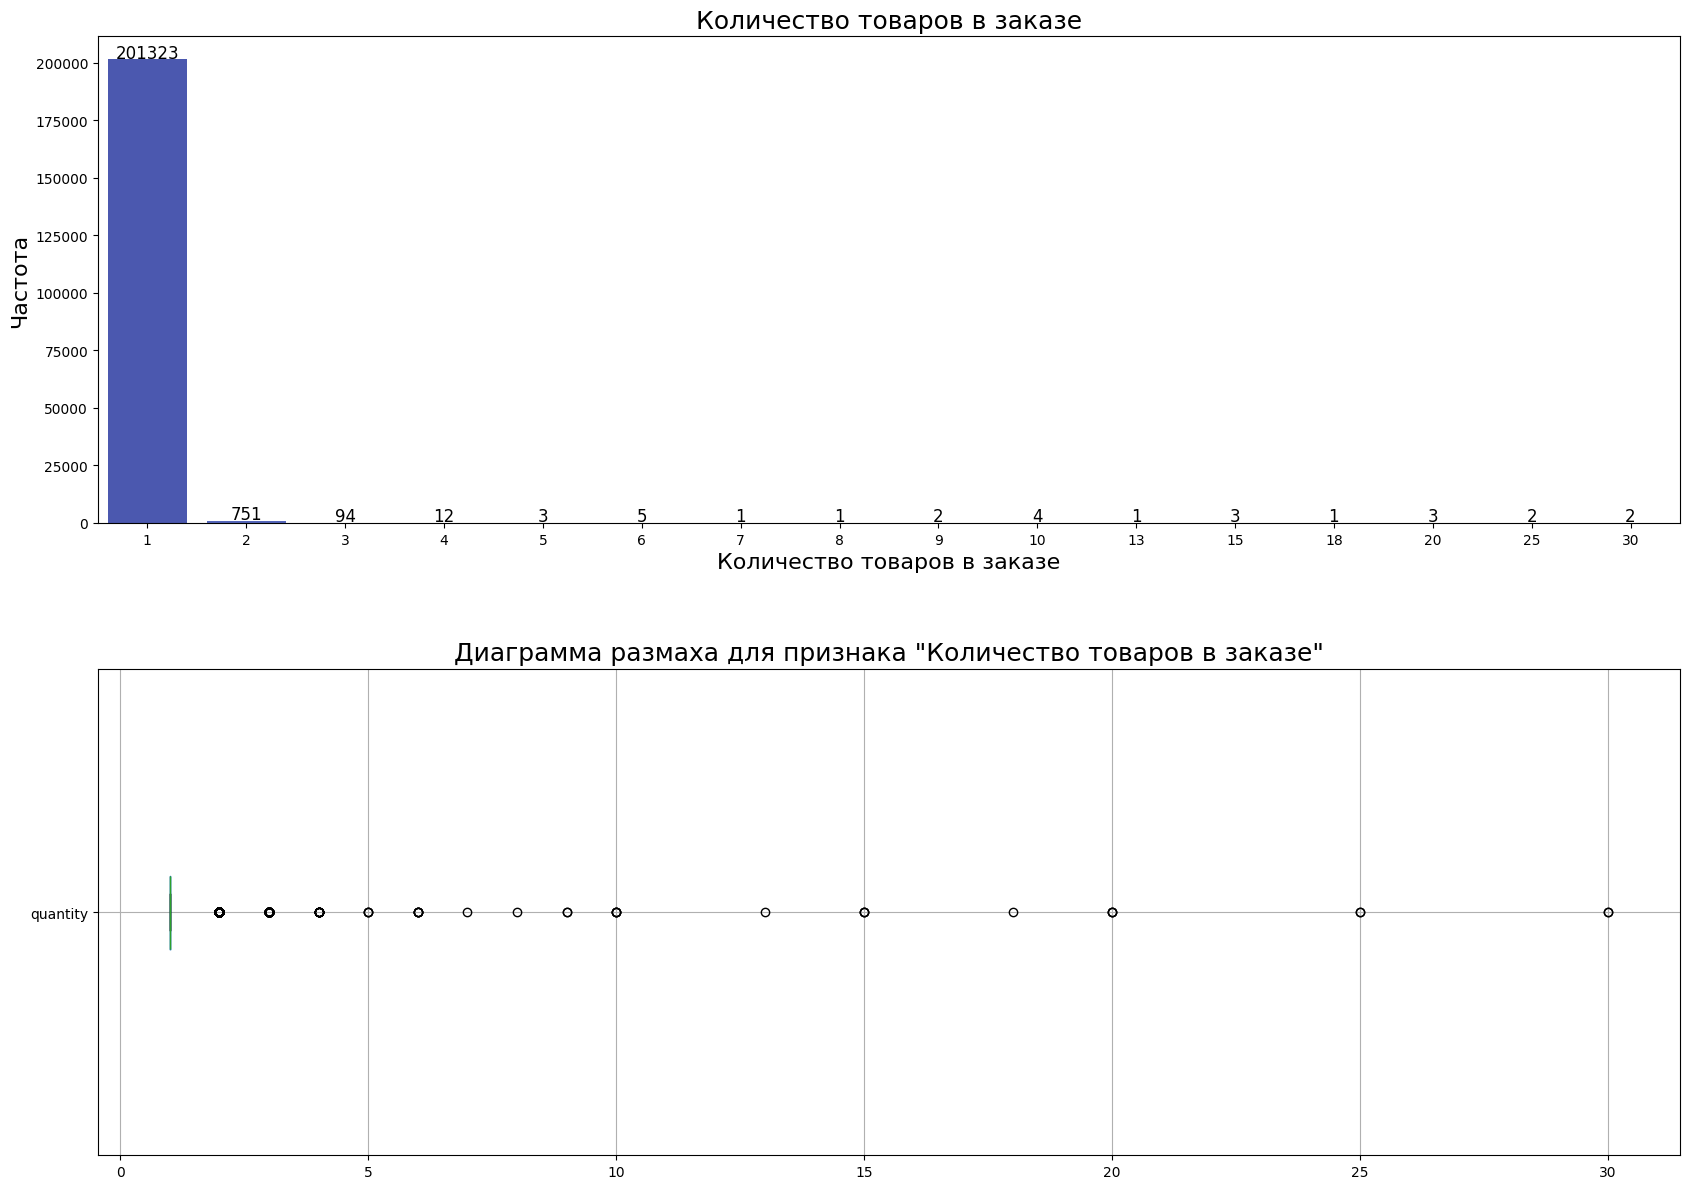

In [164]:
analyze_discrete_data(purchases, 'quantity', 'Количество товаров в заказе')

In [165]:
grouped_data = (
        purchases
        .groupby('quantity')
        .agg(
            count=('client_id', 'count'),
            percent=('client_id', lambda x: 100 * x.count() / purchases.shape[0])
        )
        .sort_values(by='count', ascending=False)
    )
grouped_data

,count,percent
quantity,,
1,201323,99.562332
2,751,0.371400
3,94,0.046487
4,12,0.005934
6,5,0.002473
10,4,0.001978
5,3,0.001484
15,3,0.001484
20,3,0.001484


Число товаров находится в промежутке от 1 до 30.  Чаще всего количество товара в покупке равно 1 (99.56% случаев). Значения больше 1 являются редкими.

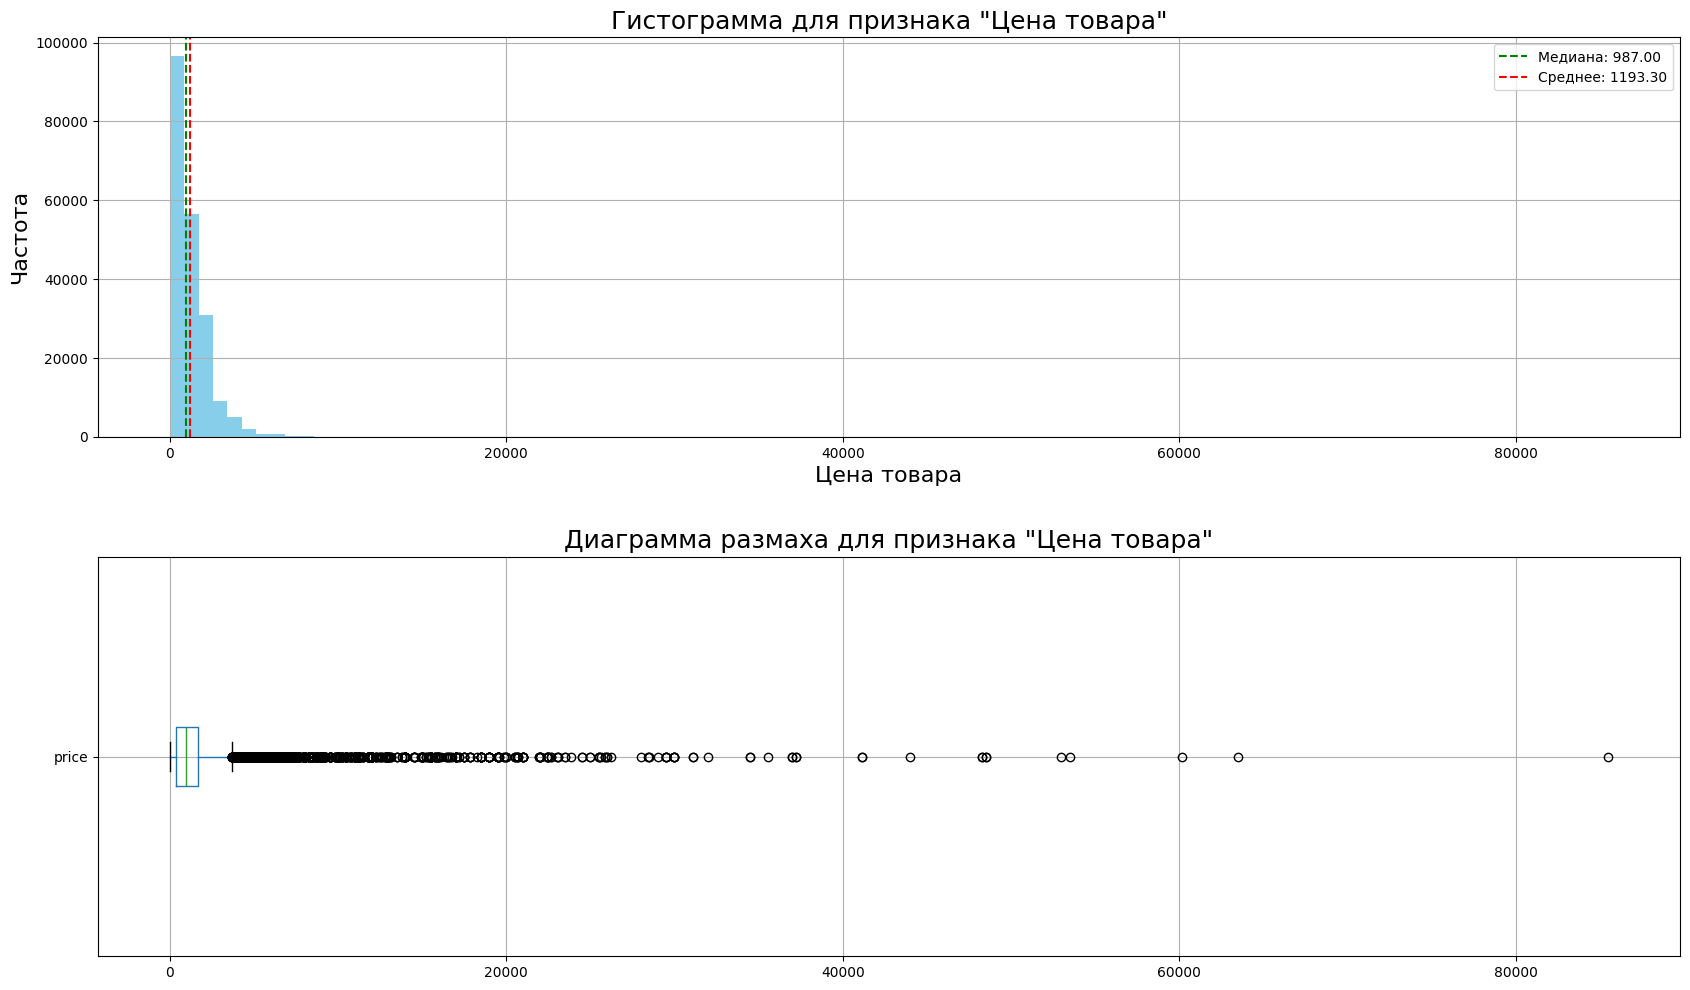

In [166]:
analyze_numerical_data(purchases, 'price', 'Цена товара')

In [167]:
purchases['price'].describe()

,price
count,202208.000000
mean,1193.301516
std,1342.252664
min,1.000000
25%,352.000000
50%,987.000000
75%,1699.000000
max,85499.000000


In [168]:
# получим крайнее значение, которое не является выбросом
whishi = boxplot_stats(purchases['price'])[0]['whishi']
whishi

3713.0

Значение цены товара находится в промежутке от 1 до 85 499. Межквартильный размах - от 352 до 1 699. Среднее значение - 1 193, медианное - 987. Случаи покупок товаров на маркетплейсе, стоимость которых превышает 3 713, являются редкими.

Посчитаем стоимость покупок.

In [169]:
purchases['cost'] = purchases['price'] * purchases['quantity']

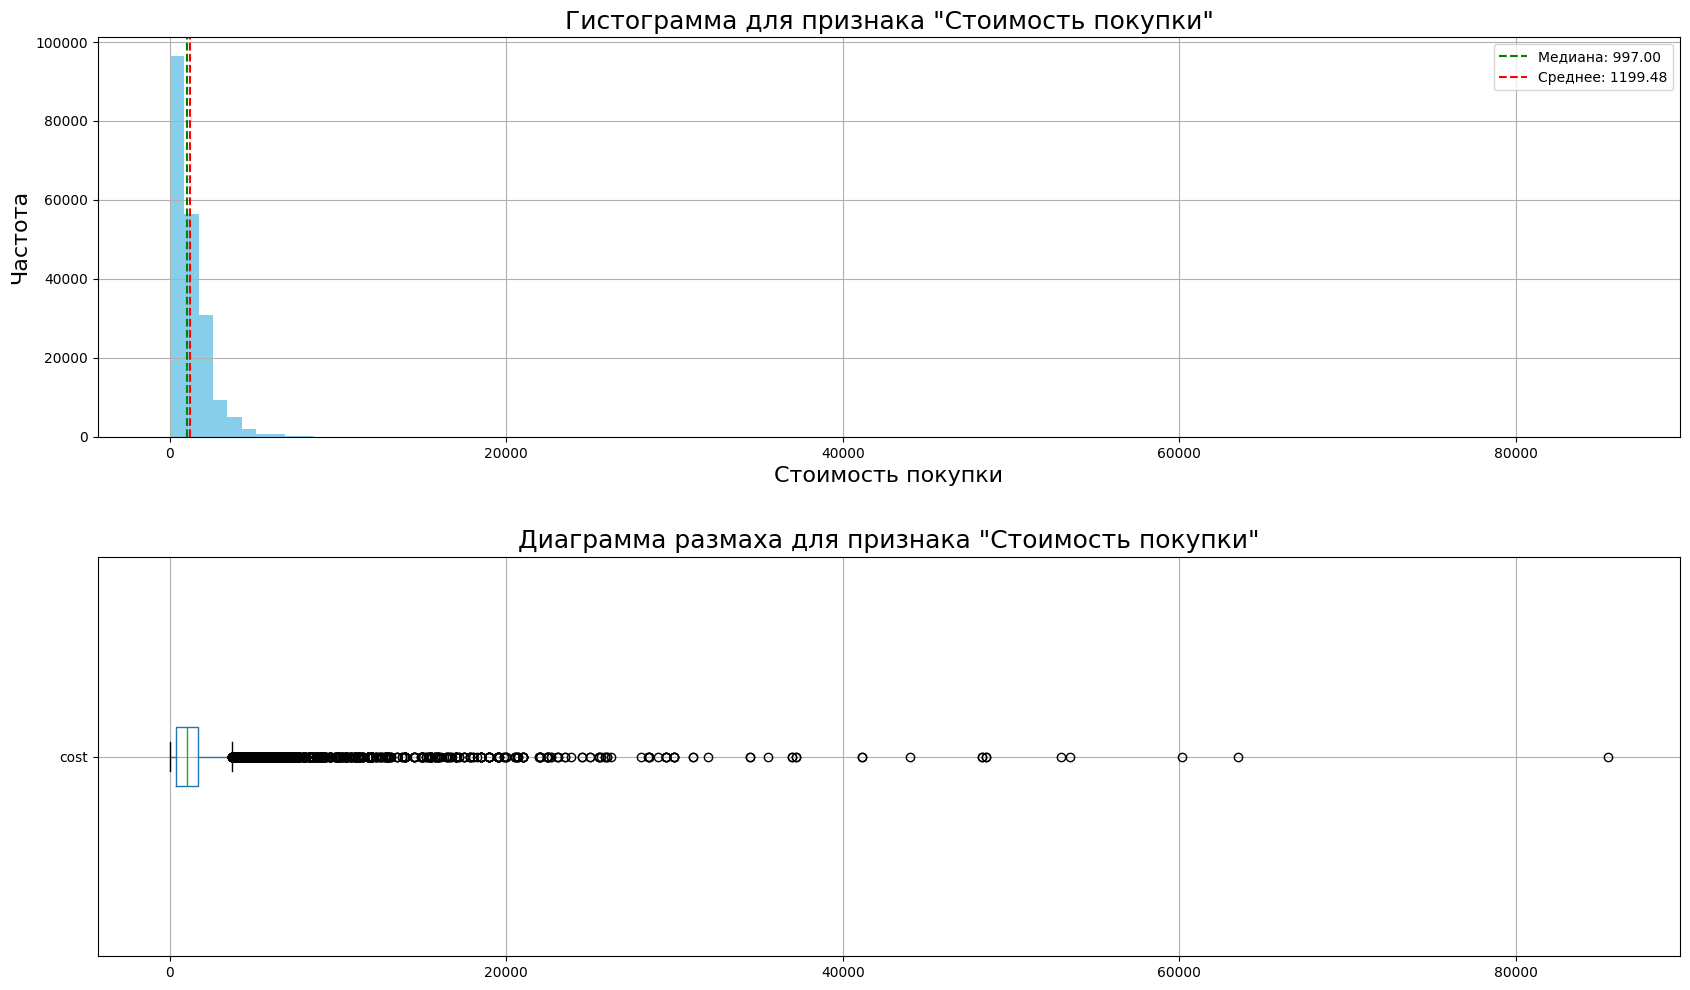

In [170]:
analyze_numerical_data(purchases, 'cost', 'Стоимость покупки')

In [171]:
purchases['cost'].describe()

,cost
count,202208.000000
mean,1199.480288
std,1355.024588
min,1.000000
25%,355.000000
50%,997.000000
75%,1699.000000
max,85499.000000


Стоимость покупки находится в диапазоне от 1 до 85 499. Межквартильный размах - от 355 до 1 699. Средняя стоимость покупки - 1 199, медианная стоимость - 997.

Посмотрим на идентификаторы сообщений и идентификаторы клиентов.

In [172]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,cost
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,6499.0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0


Значения `message_id` состоят из трех частей. Похоже, что первая часть должна соответствовать `client_id`.
Проверим это.

In [173]:
def check_client_id_in_message_id(row):
    """
    Функция проверяет, соответстветствует ли client_id первой части message_id.

    Args:
        row: Строка из датасета.

    Returns:
        bool
    """
    if str(row['client_id']) == row['message_id'].split('-')[0]:
        return True
    else:
        return False

In [174]:
result_of_check = purchases.apply(check_client_id_in_message_id, axis=1)
result_of_check.mean()

0.7246251384712771

In [175]:
# посмотрим на случайные строки
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,cost
172067,1515915625575984365,1,2999.0,"['4', '28', '213', '436']",2023-10-03,1515915625575984365-13887-65168459b99f1,2999.0
27016,1515915625487708912,1,1499.0,"['5562', '5631', '5608', '561']",2022-07-29,1515915625487708912-5707-62e3824297270,1499.0
62043,1515915625711591615,1,2199.0,"['5562', '5589', '5661', '1805']",2022-11-29,1515915625484441663-8218-63848a4b17658,2199.0
130002,1515915625487256160,1,1999.0,"['4', '28', '244', '432']",2023-06-09,1515915625487256160-13157-648318ce10507,1999.0
4304,1515915625634301425,1,149.0,"['5562', '5589', '5587', '1707']",2022-05-29,1515915625634301425-4617-6290658fc7372,149.0


In [176]:
# найдем число записей о покупках для клиентов,
# у которых наблюдается несоответствие в идентификаторах
list_of_client_id_with_differences = purchases[~result_of_check]['client_id']
(
    purchases[
        purchases['client_id'].isin(list_of_client_id_with_differences)]
    .groupby('client_id')
    .agg(number_of_purchases=('quantity', 'count'))
    .sort_values(by='number_of_purchases', ascending=False)
)

,number_of_purchases
client_id,
1515915625853312319,346
1515915625500232103,131
1515915625586493853,107
1515915625491913953,91
1515915625557342756,89
...,...
1515915625637697351,1
1515915625637795180,1
1515915625637880915,1


In [177]:
# определим число уникальных клиентов, которым отправлено сообщение
(
    purchases
    .groupby('message_id')
    .agg(numer_of_unique_clients=('client_id', 'nunique'))
    .value_counts()
)

,count
numer_of_unique_clients,
1,42211
2,7951
3,35
4,3
5,3
87,1


In [178]:
# определим, сколько ункальных сообщений отправлялось клиенту
# и построим таблицу частоты отправки таког очисла сообщений
(
    purchases
    .groupby('client_id')
    .agg(numer_of_unique_messages=('message_id', 'nunique'))
    .value_counts()
)

,count
numer_of_unique_messages,
1,43845
2,4538
3,922
4,326
5,118
6,46
7,21
8,14
9,7


Наблюдаем несоответствие client_id первой части message_id для 28% записей. По некоторым таким client_id меется всего одна запись о покупке. Для данного датасета не наблюдаем однозначного соответствия, один message_id не всегда соотвествует одному client_id.

Стоит уточнить у поставщика данных порядок формирования message_id, в случае, если наше предположение верное, выяснить причину несоответствия и получить качественные данные для работы.

In [179]:
# количество уникальных строк - вложенных категорий
purchases['category_ids'].nunique()

933

Преобразуем строку в список категорий. Если категория не указана, используем значение "unknown".

In [180]:
# определим длину строк значений столбца category_ids
purchases['category_ids'].apply(lambda x: len(x)).unique()

array([24, 25, 26, 31, 32, 29, 27, 28,  6,  2, 18, 19, 20])

В ходе отладки кода выявили наличие значений "[]" и "[None]" в столбце category_ids.

In [181]:
purchases[purchases['category_ids']=="[]"].shape[0]

5579

In [182]:
purchases[purchases['category_ids']=="[None]"].shape[0]

1264

In [183]:
def process_categories(row):
    if row == "[None]" or row == "[]":
        return ["unknown"]
    else:
        row = row.strip('[]').replace("'", "").split(', ')
        l = [x for x in row]
        return l

purchases['category_ids'] = purchases['category_ids'].apply(process_categories)

In [184]:
purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,cost
42026,1515915625491764349,1,99.0,"[5562, 5634, 5628, 574]",2022-11-04,1515915625470665776-7602-6364bc1ce5f21,99.0
171165,1515915625500427796,1,6.0,[unknown],2023-09-27,1515915625566780555-13868-6513cb935ab4d,6.0
29798,1515915625761874391,1,599.0,"[4, 28, 49, 413]",2022-08-07,1515915625490473954-5785-62ecc385320d5,599.0
178551,1515915625998679289,1,1399.0,"[4, 28, 62, 656]",2023-11-11,1515915625551103205-14085-654e43006c540,1399.0
100340,1515915625470698844,1,1299.0,"[4, 28, 146, 548]",2023-04-09,1515915625470698844-11608-642fdcace226b,1299.0


> В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

Т.к. вложенность согласно описанию датасета может меняться, использовать весь список не имеет смысла. Выделим самую верхнюю категорию (т.к. это может быть маркер распродажи либо самая обощающая категория товаров) и самую нижнюю.

In [185]:
purchases['category_first'] = purchases['category_ids'].apply(lambda x: x[0])
purchases['category_last'] = purchases['category_ids'].apply(lambda x: x[-1])
purchases.sample(10)

,client_id,quantity,price,category_ids,date,message_id,cost,category_first,category_last
16630,1515915625794702997,1,2999.0,"[5562, 5589, 5586, 1766]",2022-06-23,1515915625794702997-5108-62b471f20f277,2999.0,5562,1766
179854,1515915625569012303,1,199.0,"[4, 28, 62, 656]",2023-11-21,1515915625566326809-14150-655b597454584,199.0,4,656
28388,1515915625488777688,1,1799.0,"[4, 28, 260, 420]",2022-08-03,1515915625488777688-5782-62ea2eaf26c37,1799.0,4,420
39852,1515915625503000446,1,1092.0,"[4, 28, 275, 421]",2022-09-13,1515915625566606899-5707-62e3824007aa5,1092.0,4,421
3175,1515915625487346390,1,1699.0,"[5562, 5630, 5667, 551]",2022-05-25,1515915625566861559-4517-628b2d99e6e88,1699.0,5562,551
112150,1515915625577601845,1,557.0,"[4, 28, 343, 425]",2023-04-28,1515915625491394690-12218-644b836028e61,557.0,4,425
10638,1515915625491761205,1,599.0,"[4, 27, 142, 496]",2022-06-04,1515915625491761205-4710-6299a5b01015a,599.0,4,496
174903,1515915625585562057,1,260.0,"[4, 27, 287, 513]",2023-10-31,1515915625585562057-14024-653f86692bced,260.0,4,513
184713,1515915625585467870,1,140.0,"[5562, 5632, 5546, 966]",2023-12-22,1515915625585467870-14364-658438c1e0cab,140.0,5562,966
89192,1515915625634598279,1,700.0,"[4, 28, 275, 673]",2023-03-05,1515915625634684531-10619-6401de9092832,700.0,4,673


In [186]:
# число уникальных категорий
purchases['category_first'].nunique(), purchases['category_last'].nunique()

(9, 843)

In [187]:
(
    purchases
    .groupby('category_first')
    .agg(count_of_purchase=('client_id', 'count'))
    .sort_values('count_of_purchase', ascending=False)
)

,count_of_purchase
category_first,
4,112578
5562,46511
2,27429
6060,7559
unknown,6843
5963,1272
3,11
1,3
5,2


In [188]:
(
    purchases
    .groupby('category_last')
    .agg(count_of_purchase=('client_id', 'count'))
    .sort_values('count_of_purchase', ascending=False)
)

,count_of_purchase
category_last,
431,8626
420,6989
unknown,6843
432,6821
421,4936
...,...
1727,1
1775,1
5950,1


Больше всего за представленный период куплено товаров из категорий 4, 5562 и 2. Низкое число покупок в категориях 3, 1, 5 может быть связано с особенностями товаров (например, сезонность), с особенностями формирования пути пользователя (вложенность может меняться). Видим, что число покупок в зависимости от первой категории значимо различается.

Уникальных значений для последней категории слишком много - 843.

### messages

In [189]:
messages['date'].min(), messages['date'].max()

(Timestamp('2022-05-19 00:00:00'), Timestamp('2024-02-15 00:00:00'))

In [190]:
messages['created_at'].min(), messages['date'].max()

(Timestamp('2022-05-19 00:14:20'), Timestamp('2024-02-15 00:00:00'))

У нас есть информация по сообщениям, отправленным в период с 19.05.2022 по 15.02.2024. Временной период соответствует датасету с информацией о покупках, поэтому будем использовать принятую дату выгрузки для датасета purchases.

Посмотрим чуть подробнее на данные, чтобы убедиться, что мы верно понимаем их структуру.

In [191]:
# сообщение с идентификатором message_id отправлялось только одному пользователю
messages.groupby(['message_id']).agg(unique_users=('client_id', 'nunique')).sort_values('unique_users', ascending=False)

,unique_users
message_id,
1515915625468060902-10022-63e5ededd911f,1
1515915625559960937-5602-62daa9ec96fa6,1
1515915625559960937-14450-659e4febbae0b,1
1515915625559960937-14446-659cf9fee941c,1
1515915625559960937-14441-659cc4f5071a3,1
...,...
1515915625490177663-14184-65606706eb868,1
1515915625490177663-14156-655c71ff22e0a,1
1515915625490177663-14150-655c48060679b,1


Одному идентификатору сообщения соответсвует только один уникальный идентификатор пользователя. Еще один указатель на то, что в датасете `purchases` присутствует ошибка в части идентификаторов сообщений.

In [192]:
(
    messages
    .groupby(['client_id','bulk_campaign_id'])
    .agg(unique_mess=('message_id', 'nunique'))
    .sort_values('unique_mess', ascending=False)
)

unique_mess
client_id           bulk_campaign_id             
1515915625630462341 14276                       9
1515915625805867838 14276                       9
1515915625491388604 14276                       9
1515915625573467732 14276                       9
1515915625489957084 14276                       9
...                                           ...
1515915625490178471 14293                       1
                    14265                       1
                    14263                       1
                    14258                       1
1515915626010261344 14648                       1

[7820587 rows x 1 columns]

В рамках одной рекламной кампании 1 пользователю отправлялись от 1 до 9 сообщений.

In [193]:
# одному сообщению соответсвует одно и более действий
messages.groupby(['message_id']).agg(unique_act=('event', 'nunique')).sort_values('unique_act', ascending=False)

,unique_act
message_id,
1515915625491361167-11952-643e7913d60c5,6
1515915625588077337-6374-63241bb3c8b77,6
1515915625487574996-11608-642fdc843ea7b,6
1515915625761322791-6223-630c908a1447f,5
1515915625489075209-5335-62c7d2e6bf6e2,5
...,...
1515915625490982970-5563-62d95f6fde7c1,1
1515915625490982970-5548-62d931de65fec,1
1515915625490982970-5523-62d6b8ef21573,1


In [194]:
messages['bulk_campaign_id'].nunique()

2706

In [195]:
(
    messages
    .groupby('bulk_campaign_id')
    .agg(
        unique_mess=('message_id', 'nunique'),
        unique_users=('client_id', 'nunique'))
).describe()

,unique_mess,unique_users
count,2706.000000,2706.000000
mean,2920.223208,2890.091279
std,5419.316668,5269.510700
min,1.000000,1.000000
25%,22.000000,22.000000
50%,77.500000,77.500000
75%,3712.500000,3710.000000
max,60997.000000,26765.000000


Датасет содержит информацию о рассылках в рамках 2 706 рекламных кампаний. Во время одной кампании было отправлено от 1 до 60997 сообщений. Рассылка производилась от 1 до 26 765  пользователям.

Рассмотрим идентификаторы, которые есть в датасете: `client_id`, `bulk_campaign_id`, `message_id`. Как уже говорилось выше, `message_id` состоит из трех частей.  Первая выглядит как `client_id`, вторая может соответствовать `bulk_campaign_id` ,а третья - уже уникальный идентификатор сообщения. Проверим это.

In [196]:
def check_parts_of_message_id(row):
    """
    Функция проверяет, соответстветствует ли client_id первой части message_id,
    bulk_campaign_id второй части message_id.

    Args:
        row: Строка из датасета.

    Returns:
        bool
    """
    if (
        (str(row['client_id']) == row['message_id'].split('-')[0]) &
        (str(row['bulk_campaign_id']) == row['message_id'].split('-')[1])
        ):
        return True
    else:
        return False

In [197]:
result_of_check = messages.apply(check_parts_of_message_id, axis=1)
result_of_check.mean()

1.0

Полное совпадение для всех записей. Приходим к выводу, что наше предположение верное. А информация об идентификаторах сообщений в датасете `purchase` содержит ошибки, на нее опираться нельзя.

Посмотрим на типы действий.

In [198]:
(
    messages
    .groupby('event')
    .agg(
        count=('client_id', 'count'),
        percent=('client_id', lambda x: 100 * x.count() / messages.shape[0])
         )
    .sort_values(by='percent', ascending=False)
)

,count,percent
event,,
send,7898997,72.380229
open,2485299,22.773336
click,443970,4.068194
purchase,55704,0.510428
hard_bounce,16366,0.149965
soft_bounce,8915,0.081690
unsubscribe,2614,0.023953
hbq_spam,760,0.006964
complain,495,0.004536


Распределение выглядит реалистично: наибольшее количество событий - отправка сообщений (72.38%), далее по убывающей - открытие (22.77%), клик(4.06%), покупка (0.51%). Остальные события происходят намного реже.

In [199]:
# доля сообщений, по которым совершили покупки
messages[messages['event']=='purchase']['message_id'].nunique() / messages['message_id'].nunique()

0.005630511492859388

Если рассмотреть уникальные сообщения, то доля сообщений, по которым в итоге совершили покупки, составляет 0.56%.

In [200]:
(
    messages
    .groupby('channel')
    .agg(count_messages=('message_id','nunique'),
         percent=('message_id', lambda x: 100 * x.nunique() / messages['message_id'].nunique())
    )
)

,count_messages,percent
channel,,
email,3631008,45.949772
mobile_push,4271116,54.050228


In [201]:
(
    messages[(messages['channel']=='email') &
             (messages['event']=='purchase')]['message_id'].nunique() /
     messages[messages['channel']=='email']['message_id'].nunique()
)

0.00830843666552098

In [202]:
(
    messages[(messages['channel']=='mobile_push') &
             (messages['event']=='purchase')]['message_id'].nunique() /
     messages[messages['channel']=='mobile_push']['message_id'].nunique()
)

0.0033539243607525527

Чаще сообщения отправлялись как push-уведомления - 54.05%, реже по email - 45.9%. Доля сообщений, приведших к покупке, при взаимодействии посредством email - 0.0083, мобильных уведомлений - 0.0034.

__Промежуточный вывод__:
- наблюдается сильный дисбаланс классов в целевой переменной,
- проанализировали датасет 'purchases'.  По каждому клиенту есть от 1 до 346 записей о покупках. Датасет содержит сведения о покупках с 16.05.2022 по 16.02.2024. Число товаров находится в промежутке от 1 до 30. Чаще всего количество товара в покупке равно 1 (99.56% случаев). Значение цены товара находится в промежутке от 1 до 85 499. Межквартильный размах - от 352 до 1 699. Среднее значение - 1 193, медианное - 987. Случаи покупок товаров на маркетплейсе, стоимость которых превышает 3 713, являются редкими. Стоимость покупки находится в диапазоне от 1 до 85 499. Межквартильный размах - от 355 до 1 699. Средняя стоимость покупки - 1 199, медианная стоимость - 997. Выделили самую верхнюю категорию в отдельный столбец.
- в датасете 'purchases' присутствуют ошибочные данные в столбце 'message_id',
- датасет 'messages' содержит информацию о рассылках в рамках 2 706 рекламных кампаний. Во время одной кампании было отправлено от 1 до 60997 сообщений. Рассылка производилась от 1 до 26 765 пользователям. В рамках одной рекламной кампании 1 пользователю отправлялись от 1 до 9 сообщений.
Доля сообщений, по которым в итоге совершили покупки, составляет 0.56%.



## Создание новых признаков

### purchases

Количество единиц товара практически одинаково для всех записей, поэтому в качестве признака использовать не будем. Распределение цены и стоимости практически одинаковое, признаки будут коллинеарны, будем использовать только стоимость.

In [203]:
agg_purchases = (
    purchases
    .groupby('client_id')
    .agg(
        # общее количество покупок
        total_purchases=('quantity', 'count'),
        # итоговая стоимость за все
        total_cost=('cost', 'sum'),

        # период активности
        period_of_activity=('date', lambda x: (x.max() - x.min()).days),
        # дальность последней покупки
        days_since_last_purchase=('date', lambda x: (date_of_unloading - x.max()).days),
        # количество дней, в которые совершались покупки
        days_with_purchases=('date', 'nunique'),

        set_first_categories=('category_first', lambda x: list(x.unique())),
        most_popular_first_category=('category_first', lambda x: x.value_counts().index[0])
    )
)
agg_purchases['purchase_per_day'] = agg_purchases['total_purchases'] / agg_purchases['days_with_purchases']

In [204]:
# Применение MultiLabelBinarizer
mlb = MultiLabelBinarizer()
category_matrix = mlb.fit_transform(agg_purchases['set_first_categories'])

# Преобразуем в DataFrame
category_df = pd.DataFrame(category_matrix, columns='ctg_' + mlb.classes_)

# Соединяем с исходным DataFrame, сбросив индексы
agg_purchases = agg_purchases.reset_index(drop=False)
category_df = category_df.reset_index(drop=True)
agg_purchases = pd.concat([agg_purchases, category_df], axis=1)

In [205]:
agg_purchases.head()

,client_id,total_purchases,total_cost,period_of_activity,days_since_last_purchase,days_with_purchases,set_first_categories,most_popular_first_category,purchase_per_day,ctg_1,ctg_2,ctg_3,ctg_4,ctg_5,ctg_5562,ctg_5963,ctg_6060,ctg_unknown
0,1515915625468060902,7,6993.0,0,631,1,[4],4,7.000000,0,0,0,1,0,0,0,0,0
1,1515915625468061003,7,16235.0,0,409,1,[4],4,7.000000,0,0,0,1,0,0,0,0,0
2,1515915625468061099,1,299.0,0,641,1,[4],4,1.000000,0,0,0,1,0,0,0,0,0
3,1515915625468061100,2,2098.0,0,7,1,[4],4,2.000000,0,0,0,1,0,0,0,0,0
4,1515915625468061170,19,33601.0,83,245,3,"[unknown, 2, 4]",4,6.333333,0,1,0,1,0,0,0,0,1


In [206]:
agg_purchases = agg_purchases.drop(['set_first_categories'], axis=1)
agg_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   total_purchases              49849 non-null  int64  
 2   total_cost                   49849 non-null  float64
 3   period_of_activity           49849 non-null  int64  
 4   days_since_last_purchase     49849 non-null  int64  
 5   days_with_purchases          49849 non-null  int64  
 6   most_popular_first_category  49849 non-null  object 
 7   purchase_per_day             49849 non-null  float64
 8   ctg_1                        49849 non-null  int64  
 9   ctg_2                        49849 non-null  int64  
 10  ctg_3                        49849 non-null  int64  
 11  ctg_4                        49849 non-null  int64  
 12  ctg_5                        49849 non-null  int64  
 13  ctg_5562        

### messages

In [207]:
agg_messages = (
    messages
    .groupby('client_id')
    .agg(
        total_messages=('message_id', 'nunique'),
        share_of_phone_msgs=('channel', lambda x: (x == 'mobile_push').sum()/x.count()),


        days_in_communication=('date', 'nunique'),
        period_of_interaction=('date', lambda x: (x.max() - x.min()).days),
        days_since_last_msg=('date', lambda x: (date_of_unloading - x.max()).days),

        share_of_involment=('event', lambda x: (x.isin(['open', 'click', 'purchase', 'subscribe'])).sum()/x.count()),
        share_of_negative_feedback=('event', lambda x: (x.isin(['unsubscribe', 'complain'])).sum()/x.count()),

        share_of_open=('event', lambda x: (x == 'open').sum()/x.count()),
        share_of_click=('event', lambda x: (x == 'click').sum()/x.count()),
        share_of_purchase=('event', lambda x: (x == 'purchase').sum()/x.count()),
        share_of_subscribe=('event', lambda x: (x == 'subscribe').sum()/x.count()),
        share_of_unsubscribe=('event', lambda x: (x == 'unsubscribe').sum()/x.count()),
        share_of_complain=('event', lambda x: (x == 'complain').sum()/x.count())

    )
)
agg_messages['messages_per_day']=agg_messages['total_messages']/agg_messages['days_in_communication']

In [208]:
agg_messages = agg_messages.reset_index(drop=False)

In [209]:
set(agg_messages['client_id']).issubset(set(target_binary['client_id']))

True

### Получение итогового датасета

In [210]:
data = (
    target_binary
    .merge(agg_purchases, on='client_id', how='left')
    .merge(agg_messages, on='client_id', how='left')
    .reset_index(drop=True)
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   target                       49849 non-null  int64  
 2   total_purchases              49849 non-null  int64  
 3   total_cost                   49849 non-null  float64
 4   period_of_activity           49849 non-null  int64  
 5   days_since_last_purchase     49849 non-null  int64  
 6   days_with_purchases          49849 non-null  int64  
 7   most_popular_first_category  49849 non-null  object 
 8   purchase_per_day             49849 non-null  float64
 9   ctg_1                        49849 non-null  int64  
 10  ctg_2                        49849 non-null  int64  
 11  ctg_3                        49849 non-null  int64  
 12  ctg_4                        49849 non-null  int64  
 13  ctg_5           

In [211]:
data.head()

,client_id,target,total_purchases,total_cost,period_of_activity,days_since_last_purchase,days_with_purchases,most_popular_first_category,purchase_per_day,ctg_1,...,days_since_last_msg,share_of_involment,share_of_negative_feedback,share_of_open,share_of_click,share_of_purchase,share_of_subscribe,share_of_unsubscribe,share_of_complain,messages_per_day
0,1515915625468060902,0,7,6993.0,0,631,1,4,7.000000,0,...,29.0,0.282486,0.00565,0.197740,0.056497,0.028249,0.0,0.00565,0.0,0.933824
1,1515915625468061003,1,7,16235.0,0,409,1,4,7.000000,0,...,4.0,0.066667,0.00000,0.030303,0.030303,0.006061,0.0,0.00000,0.0,0.993548
2,1515915625468061099,0,1,299.0,0,641,1,4,1.000000,0,...,4.0,0.213768,0.00000,0.184783,0.028986,0.000000,0.0,0.00000,0.0,1.125654
3,1515915625468061100,0,2,2098.0,0,7,1,4,2.000000,0,...,2.0,0.371495,0.00000,0.366822,0.002336,0.002336,0.0,0.00000,0.0,1.175439
4,1515915625468061170,0,19,33601.0,83,245,3,4,6.333333,0,...,2.0,0.170648,0.00000,0.105802,0.054608,0.010239,0.0,0.00000,0.0,1.146226


In [212]:
data.isna().sum()

,0
client_id,0
target,0
total_purchases,0
total_cost,0
period_of_activity,0
days_since_last_purchase,0
days_with_purchases,0
most_popular_first_category,0
purchase_per_day,0
ctg_1,0


Число пропусков совпадает с числом отсутствующих client_id в messages. Заполним медианой.

In [213]:
cols_msgs_int = [
                'total_messages',
                'days_in_communication',
                 'period_of_interaction',
                 'days_since_last_msg'
]

cols_msgs_float = [
    'share_of_phone_msgs',
    'share_of_purchase',
    'share_of_involment',
    'share_of_negative_feedback',
    'messages_per_day',
    'share_of_open',
    'share_of_click',
    'share_of_subscribe',
    'share_of_unsubscribe',
    'share_of_complain'
   ]

data[cols_msgs_int + cols_msgs_float] = data[cols_msgs_int + cols_msgs_float].fillna(data[cols_msgs_int + cols_msgs_float].median())
data[cols_msgs_int] = data[cols_msgs_int].astype(int)

In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   client_id                    49849 non-null  int64  
 1   target                       49849 non-null  int64  
 2   total_purchases              49849 non-null  int64  
 3   total_cost                   49849 non-null  float64
 4   period_of_activity           49849 non-null  int64  
 5   days_since_last_purchase     49849 non-null  int64  
 6   days_with_purchases          49849 non-null  int64  
 7   most_popular_first_category  49849 non-null  object 
 8   purchase_per_day             49849 non-null  float64
 9   ctg_1                        49849 non-null  int64  
 10  ctg_2                        49849 non-null  int64  
 11  ctg_3                        49849 non-null  int64  
 12  ctg_4                        49849 non-null  int64  
 13  ctg_5           

__Промежуточный вывод__:

Мы подготовили признаки, основываясь на информации датасетов `purchases` и `messages`:
- total_purchases
- total_cost
- period_of_activity
- days_since_last_purchase
- days_with_purchases
- most_popular_first_category
- purchase_per_day
- ctg_name_of_category (для всех категорий верхнего уровня)
- total_messages
- share_of_phone_msgs
- days_in_communication
- period_of_interaction
- days_since_last_msg
- share_of_involment
- share_of_negative_feedback
- share_of_open
- share_of_click
- share_of_purchase
- share_of_subscribe
- share_of_unsubscribe
- share_of_complain
- messages_per_day

Добавили признаки в датасет `target_binary`.

## Корреляционный анализ

Для удобства изучения визуализируем отдельно матрицу корреляции для данных о покупках и о сообщениях.

In [215]:
data = data.drop(columns=['client_id'])
data.columns

Index(['target', 'total_purchases', 'total_cost', 'period_of_activity',
       'days_since_last_purchase', 'days_with_purchases',
       'most_popular_first_category', 'purchase_per_day', 'ctg_1', 'ctg_2',
       'ctg_3', 'ctg_4', 'ctg_5', 'ctg_5562', 'ctg_5963', 'ctg_6060',
       'ctg_unknown', 'total_messages', 'share_of_phone_msgs',
       'days_in_communication', 'period_of_interaction', 'days_since_last_msg',
       'share_of_involment', 'share_of_negative_feedback', 'share_of_open',
       'share_of_click', 'share_of_purchase', 'share_of_subscribe',
       'share_of_unsubscribe', 'share_of_complain', 'messages_per_day'],
      dtype='object')

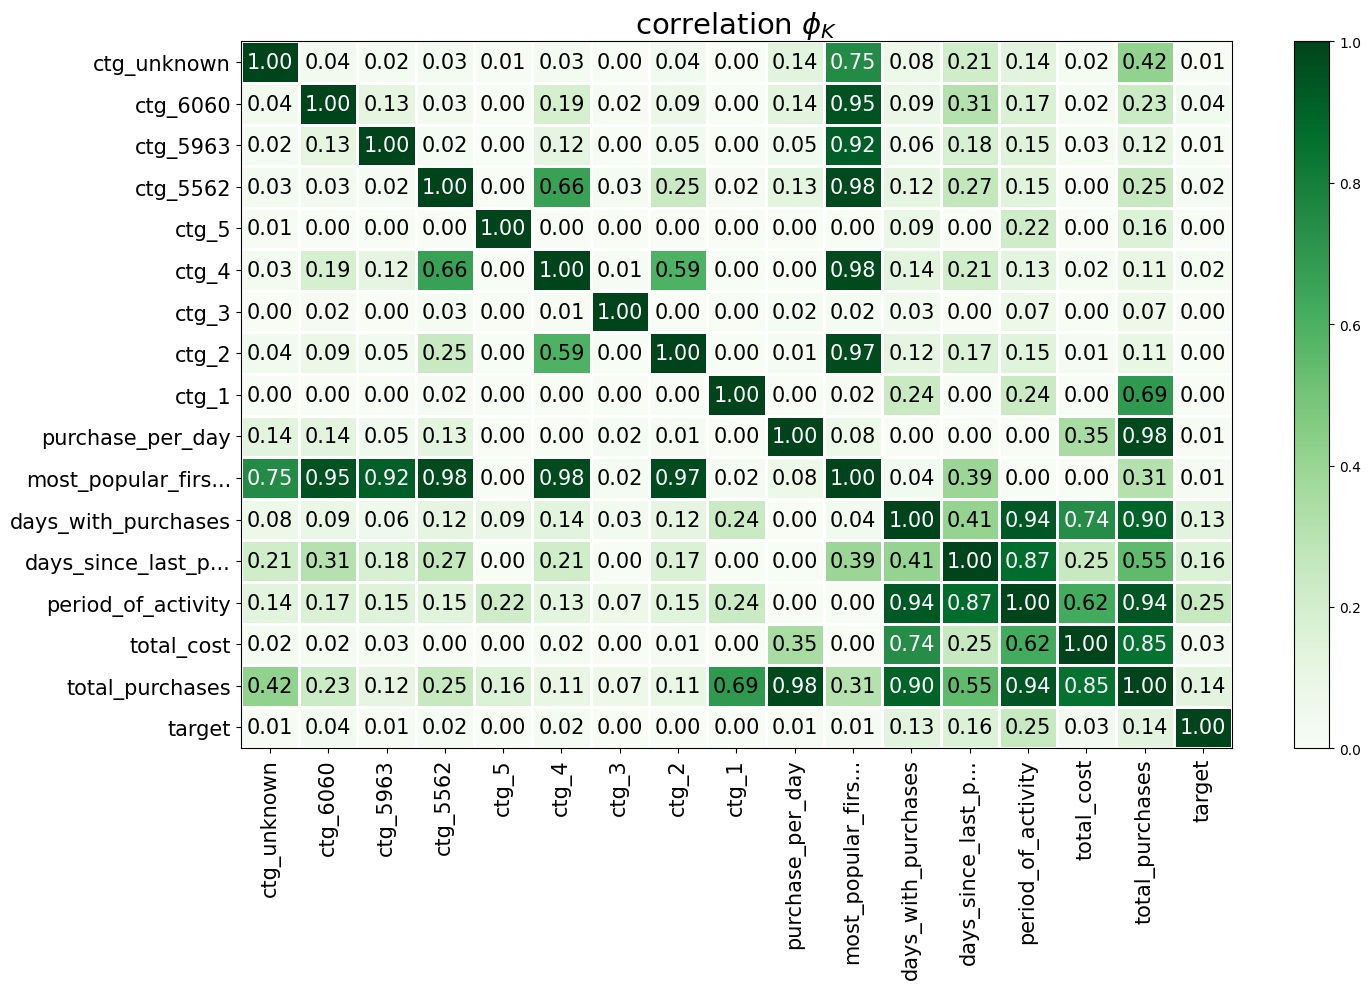

In [216]:
interval_cols = ['total_cost','purchase_per_day']


phik_overview_purchases = phik_matrix(
    data[['target', 'total_purchases', 'total_cost', 'period_of_activity',
       'days_since_last_purchase', 'days_with_purchases',
       'most_popular_first_category', 'purchase_per_day',
       'ctg_1', 'ctg_2', 'ctg_3', 'ctg_4', 'ctg_5', 'ctg_5562', 'ctg_5963',
       'ctg_6060', 'ctg_unknown'
       ]], interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview_purchases.values,
    x_labels=phik_overview_purchases.columns,
    y_labels=phik_overview_purchases.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Коррелируют с таргетом:
- ctg_(unknown, 6060, 5963, 5562, 4),
- purchases_per_day,
- most_popular_first_category,
- days_with_purchases,
- days_since_last_purchase,
- period_of_activity,
- total_cost,
- total_purchases.

Уберем некоторые признаки, между которыми сильная корреляция. Выбирая между наиболее популярной первой категорией и столбцами для каждой из категорий, оставим наиболее популярную категорию.
Остаются:
- most_popular_first_category,
- days_with_purchases,
- days_since_last_purchase,
- period_of_activity,
- total_cost,
- total_purchases.

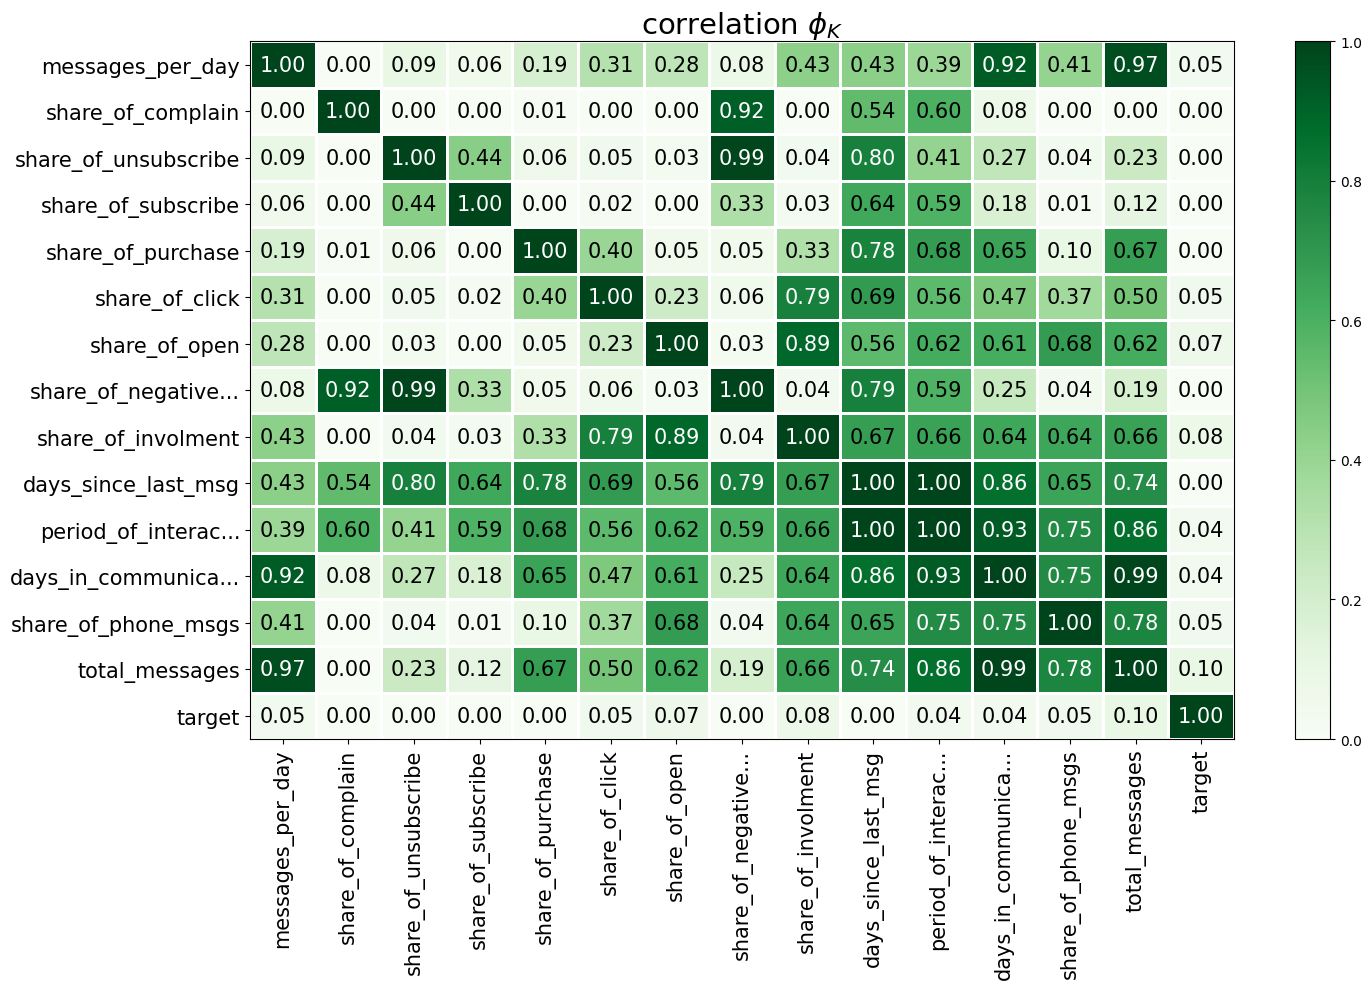

In [217]:
interval_cols = ['share_of_phone_msgs',
       'share_of_involment', 'share_of_negative_feedback', 'share_of_open',
       'share_of_click', 'share_of_purchase', 'share_of_subscribe',
       'share_of_unsubscribe', 'share_of_complain', 'messages_per_day']

phik_overview_messages = phik_matrix(
    data[['target',  'total_messages', 'share_of_phone_msgs',
       'days_in_communication', 'period_of_interaction', 'days_since_last_msg',
       'share_of_involment', 'share_of_negative_feedback', 'share_of_open',
       'share_of_click', 'share_of_purchase', 'share_of_subscribe',
       'share_of_unsubscribe', 'share_of_complain', 'messages_per_day'
       ]], interval_cols=interval_cols)


plot_correlation_matrix(
    phik_overview_messages.values,
    x_labels=phik_overview_messages.columns,
    y_labels=phik_overview_messages.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Коррелируют с таргетом:
- message_per_day
- share_of_click
- share_of_open
- share_of_involment
- period_of_interaction
- days_in_communication
- share_of_phone_msgs
- total_messages

Уберем некоторые признаки, между которыми сильная корреляция.
Остаются:
- share_of_click
- share_of_open
- share_of_involment
- period_of_interaction
- share_of_phone_msgs
- total_messages

In [218]:
# сделаем копию датасета, чтобы не потерять исходный
# будем его использовать, если решим изменить набор признаков
data_full = data.copy()

In [219]:
data = data[['target', 'share_of_click','share_of_open', 'share_of_involment',
 'period_of_interaction', 'share_of_phone_msgs', 'total_messages',
 'most_popular_first_category', 'days_with_purchases', 'days_since_last_purchase',
 'period_of_activity', 'total_cost', 'total_purchases']]

__Промежуточный вывод__:

После корреляционного анализа решили использовать признаки:
- share_of_click
- share_of_open
- share_of_involment
- period_of_interaction
- share_of_phone_msgs
- total_messages
- most_popular_first_category, (чтобы избежать шум от категорий, для которых корреляция отсутствует совсем)
- days_with_purchases
- days_since_last_purchase
- period_of_activity
- total_cost
- total_purchases

## Создание моделей

In [220]:
def search_best_estimator(model, param, X_train, y_train):
    """
    Функция ищет лучшую модель с помощью RandomizedSearchCV.
    Выводит на экран время поиска, лучшие параметры
    и ROC-AUC на кросс-валидации.

    model - модель/пайплайн
    param - словарь с гиперпараметрами
    X_train - обучающая выборка
    y_train - целевая переменная

    Args:
        model (object): модель/пайплайн
        param (dict): словарь с гиперпараметрами
        X_train (pd.DataFrame): обучающая выборка
        y_train (pd.Series): целевая переменная

    Returns:
        object: rand_search - объект RandomizedSearchCV
    """

    start_time = time.time()

    rand_search = RandomizedSearchCV(
        model,
        param,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=-1)

    rand_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    print(f'Время поиска: {search_time} cекунд')
    print(f'Лучшие параметры: {rand_search.best_params_}')
    print(f'ROC-AUC на кросс-валидации: {rand_search.best_score_}')

    return rand_search

Решаем задачу бинарной классификации, обучение с учителем, дисбаланс классов.  Вспомним цель разработки модели: предсказать вероятность совершения покупки, т.е. в большей степени нас интересует предсказание минорного класса. Необходимо учесть дисбаланс классов.   Выборки будем формировать с учетом стратификации.

Рассмотрим несколько моделей:
- CatBoostClassifier (используем `scale_pos_weight`, значение вычисляем согласно документации как отношение числа экземпляров класса 0 к числу экземпляров класса 1),
- LGBMClassifier (используем `is_unbalance=True`)
- KNeighborsClassifier
- LogisticRegression (`class_weight='balanced'`)
- DecisionTreeClassifier (`class_weight='balanced'`)
- RandomForestClassifier (`class_weight='balanced'`)

С учетом различной предобработки данных для разных моделей, а также для удобства дальнейшего анализа моделей (которые не оказались лучшими), используем RandomizedSearchCV для некоторых моделей отдельно.

### Подготовка данных

In [221]:
data.duplicated().sum()

344

In [222]:
data = data.drop_duplicates()

In [223]:
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
X_train.shape, X_test.shape

((37128, 12), (12377, 12))

In [224]:
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(exclude=['number']).columns

### CatBoostClassifier

In [225]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight

50.49514563106796

In [226]:
cb_model = CatBoostClassifier(cat_features=list(cat_cols),
                              verbose=False,
                              scale_pos_weight=pos_weight,
                              random_state=RANDOM_STATE)

cb_param = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 3, 5],
        'iterations': [100, 200, 300]}

catboost_model = search_best_estimator(cb_model, cb_param, X_train, y_train)

Время поиска: 534.8495934009552 cекунд
Лучшие параметры: {'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 4}
ROC-AUC на кросс-валидации: 0.756307703053327


### LGBMClassifier

In [227]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

for c in cat_cols:
    X_train_lgbm[c] = X_train_lgbm[c].astype('category')
    X_test_lgbm[c] = X_test_lgbm[c].astype('category')

In [228]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)
param_lgbm = {
    'num_leaves': [16, 32, 64],
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8],
    'min_child_samples': [10, 20],
    'learning_rate': [0.03, 0.1]
}

lgbm_model = search_best_estimator(model_lgbm, param_lgbm, X_train_lgbm, y_train)

[LightGBM] [Info] Number of positive: 721, number of negative: 36407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 37128, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019419 -> initscore=-3.921877
[LightGBM] [Info] Start training from score -3.921877
Время поиска: 51.78597593307495 cекунд
Лучшие параметры: {'num_leaves': 16, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 8, 'learning_rate': 0.03}
ROC-AUC на кросс-валидации: 0.7419002887356693


### KNeighborsClassifier, LogisticRegression


In [229]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', OneHotEncoder(drop='first', sparse_output=False,
                              handle_unknown='ignore'), cat_cols),
        ('num', MinMaxScaler(), num_cols)
    ],
    remainder = 'passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_set_of_models = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(4, 10),
        'models__weights': ['distance', 'uniform'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='saga')],
        'models__C': [0.01, 0.1, 1],
        'models__penalty': ['l2', 'elasticnet'],
        'models__l1_ratio': [0.2, 0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }]

rand_search_set_of_models = search_best_estimator(pipe_final, param_set_of_models, X_train, y_train)

Время поиска: 93.03235149383545 cекунд
Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__penalty': 'l2', 'models__l1_ratio': 0.2, 'models__C': 1, 'models': LogisticRegression(class_weight='balanced', random_state=42, solver='saga')}
ROC-AUC на кросс-валидации: 0.7330375351662427


### Деревья решений (DecisionTreeClassifier, RandomForestClassifier)

In [230]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),cat_cols),
        ('num', MinMaxScaler(), num_cols)
    ],
    remainder = 'passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_tree = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': [None, 5, 7, 10, 20],
        'models__min_samples_leaf': range(1, 8),
        'models__min_samples_split': range(2, 10),
        'models__max_leaf_nodes': [None, 10, 30, 50, 70],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [100, 200, 300, 400],
        'models__max_depth': [5, 10, 15],
        'models__min_samples_leaf': [4, 7, 10],
        'models__min_samples_split': [2, 3, 5]
    }
]

tree_model = search_best_estimator(pipe_tree, param_tree, X_train, y_train)

Время поиска: 11.190102338790894 cекунд
Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 9, 'models__min_samples_leaf': 4, 'models__max_leaf_nodes': 10, 'models__max_depth': 7, 'models': DecisionTreeClassifier(class_weight='balanced', random_state=42)}
ROC-AUC на кросс-валидации: 0.7103838682941419


__Промежуточный вывод__:
- создали и обучили модели с различными параметрами, учитывали дисбаланс классов (стратифицировали выборки, использовали гиперпараметры, помогающие в случае дисбаланса, кросс-валидацию).

## Выбор лучшей модели

In [231]:
def analyze_model(model, X_test, y_test):
    """
    Функция для анализа модели:
    - находит значение метрик ROC-AUC, F1-Score, Precision, Recall
    - выводит Confusion Matrix

    Args:
        model: модель
        X_test: признаки
        y_test: целевая переменная

    Returns:
        None
    """
    pred = model.predict(X_test)

    print('ROC AUC модели на тестовой выборке:', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print('F1 Score:', f1_score(y_test, pred))
    print('Precision:', precision_score(y_test, pred))
    print('Recall:', recall_score(y_test, pred))

    print('\nМатрица ошибок:')
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.ylabel('True label')
    plt.xlabel('Predicted');
    plt.show()

Лучший результат на кросс валидации __ROC-AUC: 0.76__ показала модель __CatBoostClassifier__.
Найдем значение целевой метрики ROC-AUC на тестовой выборке,  также посчитаем другие метрики и построим confusion matrix.

In [232]:
best_model = catboost_model.best_estimator_

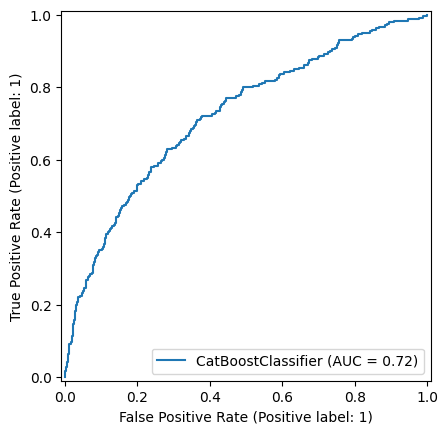

In [233]:
RocCurveDisplay.from_estimator(best_model, X_test, y_test)

ROC AUC модели на тестовой выборке: 0.7216905605448902
F1 Score: 0.08483368935001526
Precision: 0.04576885083964439
Recall: 0.5791666666666667

Матрица ошибок:


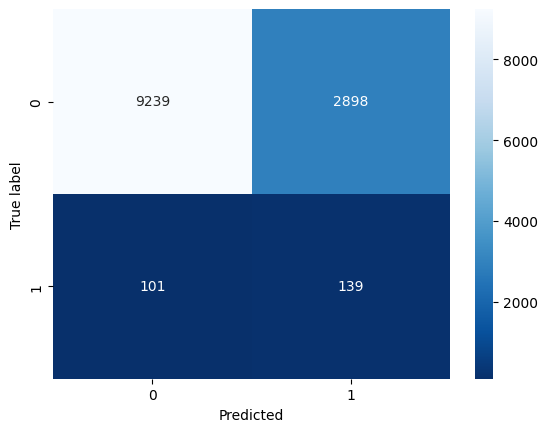

In [234]:
analyze_model(best_model, X_test, y_test)

Нашей целью было выделить пользователей, готовых совершить покупку. Recall составляет 0.579. Это значит, что модель успешно обнаружила 57.9% клиентов, которые совершат покупку (139 из 240).

Вместе с этим, очень большое число ошибок первого рода. Модель ошибочно предсказала, что 2898 клиентов готовы совершить покупку. Низкие значения precision и f1 говорят о том, что модель нуждается в улучшении.



### Проверка модели на адекватность (сравнение с Dummy)

Значение целевой метрики нашей модели лучше, чем у DummyClassifier.

In [235]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# посчитайте и выведите F1-меру
dummy_roc_auc = roc_auc_score(y_test, dummy_model.predict_proba(X_test)[:, 1])
print('ROC-AUC DummyClassifier:', dummy_roc_auc)

ROC-AUC DummyClassifier: 0.5


### Анализ важности признаков

In [236]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

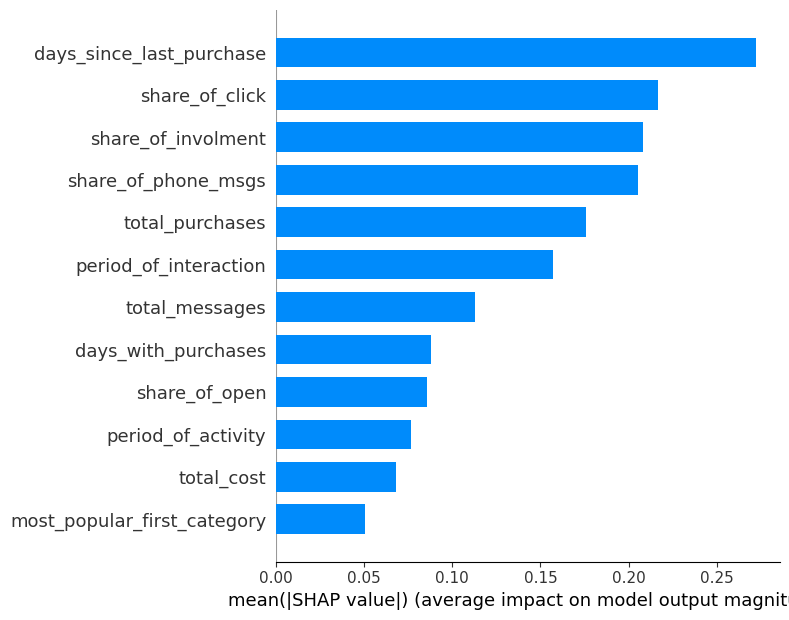

In [237]:
shap.summary_plot(shap_values, X, plot_type="bar")

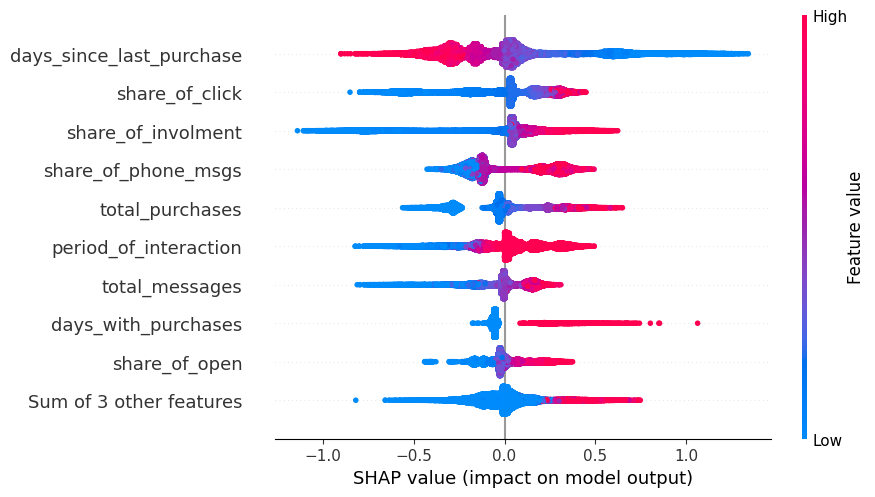

In [238]:
shap.plots.beeswarm(explainer(X_train))

Для признака days_since_last_purchases видим, что большие значение склоняют предсказание к нулю (клиент не совершит покупку). Остальные признаки оказывают обратное влияние: чем больше значение, тем больше вероятность отнесения объекта к положительному классу. Топ-3 самых значимых признака: days_since_last_purchase, share_of_click, share_of_involment.

__Промежуточный вывод__:
- Лучшая модель: CatBoostClassifier с параметрами scale_pos_weight=pos_weight, random_state=42,learning_rate=0.03, l2_leaf_reg=1, iterations=300, depth=4. Значение ROC-AUC на тестовой выборке: 0.72.
- Самые значимые признаки: days_since_last_purchase, share_of_click, share_of_involment, share_of_phone_msgs, total_purchases, period_of_interaction, total_messages.
- Модель успешно обнаружила 57.9% клиентов, которые совершат покупку (139 из 240), но число ошибок первого рода довольно большое. Модель нуждается в улучшении.

## Анализ других моделей*

В исследовательских целях рассмотрим некоторые модели, которые также показали хороший результат. Найдем для них метрики, построим матрицу ошибок и проведем анализ важности признаков.

### LGBMClassifier

ROC AUC модели на тестовой выборке: 0.7054552539067864
F1 Score: 0.08872458410351201
Precision: 0.0486815415821501
Recall: 0.5

Матрица ошибок:


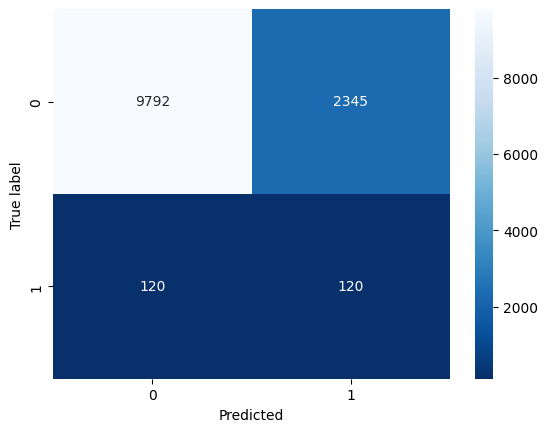


 Анализ важности признаков



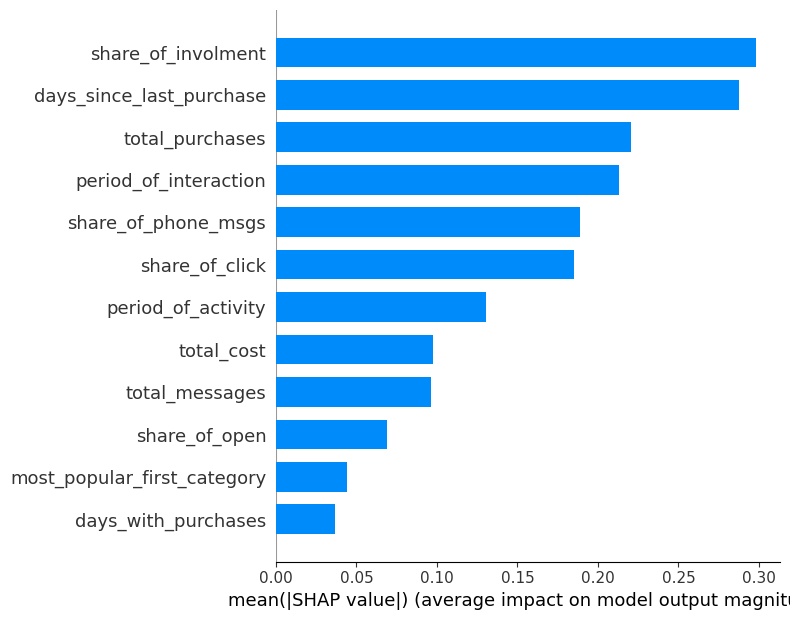

In [239]:
analyze_model(lgbm_model, X_test_lgbm, y_test)

X_lgbm = X.copy()
for c in cat_cols:
    X_lgbm[c] = X_lgbm[c].astype('category')
print('\n Анализ важности признаков\n')
explainer = shap.TreeExplainer(lgbm_model.best_estimator_)
shap_values = explainer.shap_values(X_lgbm)
shap.summary_plot(shap_values, X_lgbm, plot_type="bar")

Модель определила 50% положительных экземпляров, но при этом очень много ошибок первого рода. Самыми  важными признаками оказались share_of_involment, days_since_last_purchase, total_purchases, period_of_interaction.

### LogisticRegression

ROC AUC модели на тестовой выборке: 0.7299875037763313
F1 Score: 0.07789417136717701
Precision: 0.04163077806488659
Recall: 0.6041666666666666

Матрица ошибок:


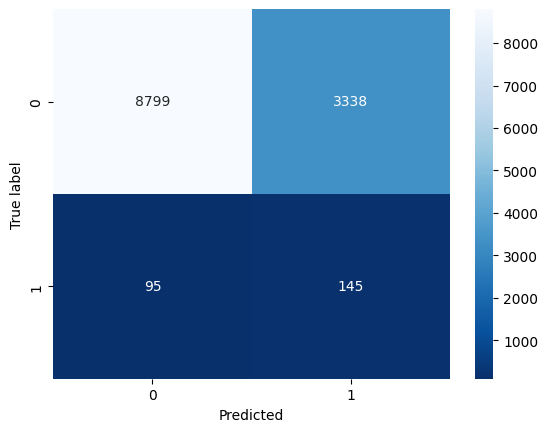


 Анализ важности признаков



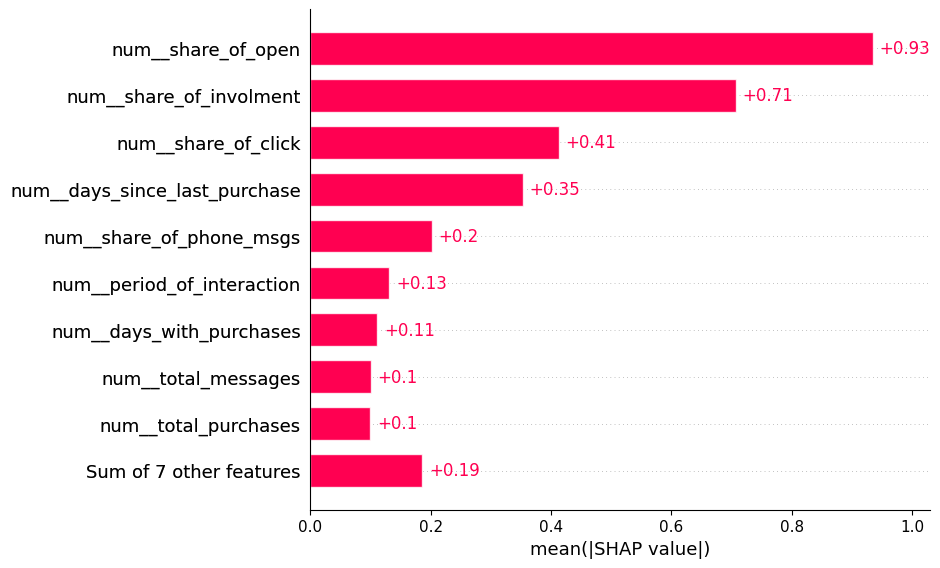

In [240]:
analyze_model(rand_search_set_of_models, X_test, y_test)
print('\n Анализ важности признаков\n')
logreg = rand_search_set_of_models.best_estimator_
X_processed = logreg.named_steps['preprocessor'].transform(X)

explainer = shap.LinearExplainer(
    logreg.named_steps['models'],
    X_processed,
    feature_names = logreg.named_steps['preprocessor'].get_feature_names_out())
shap_values = explainer(X_processed)
shap.plots.bar(shap_values)

Модель может достаточно хорошо идентифицировать реальные положительные экземпляры (Recall: 0.60), но имеется большое количество ошибок первого рода.

### DecisionTreeClassifier

ROC AUC модели на тестовой выборке: 0.6823348369998078
F1 Score: 0.06059436510999614
Precision: 0.03176851477134763
Recall: 0.6541666666666667

Матрица ошибок:


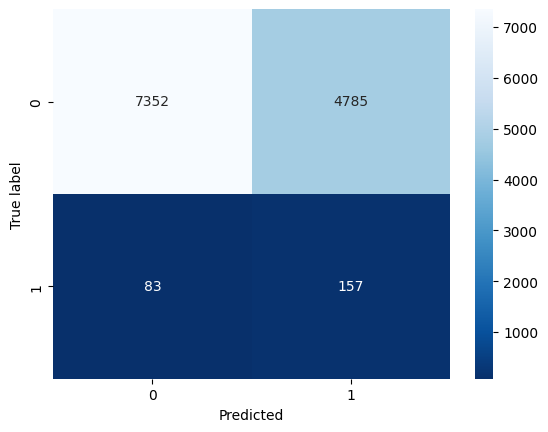


 Анализ важности признаков



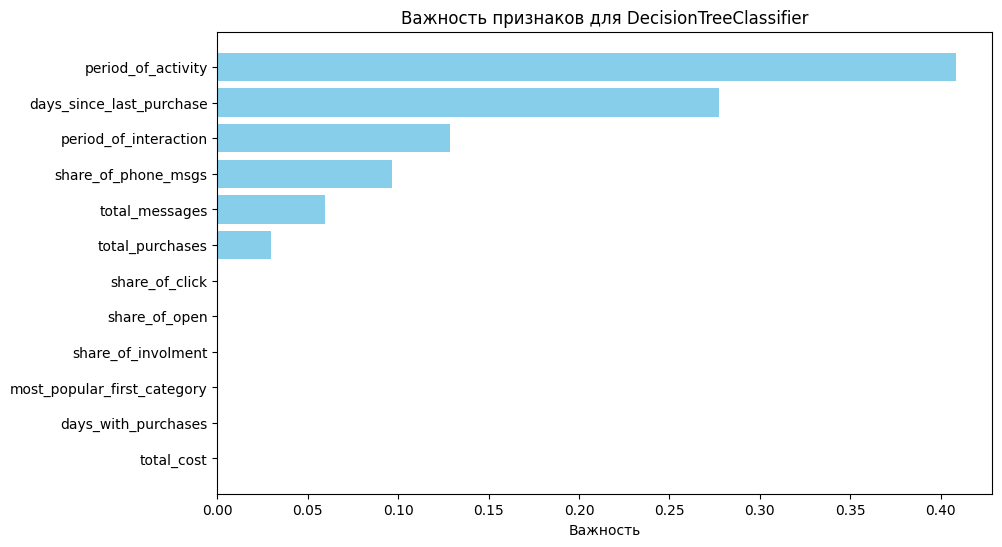

In [241]:
analyze_model(tree_model, X_test, y_test)
print('\n Анализ важности признаков\n')
feature_importances = pd.DataFrame(
    {
        'feature': X_train.columns,
        'importance': tree_model.best_estimator_.named_steps['models'].feature_importances_
    }).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Важность')
plt.title('Важность признаков для DecisionTreeClassifier')
plt.gca().invert_yaxis()
plt.show()

Несмотря на относительно хорошее значение ROC-AUC, видим слишком высокий уровень ложных срабатываний. Самыми важными признаками оказались: period_of_activity, days_since_last.

## Улучшение модели

Попробуем улучшить выбранную модель, убрав три самых малозначительных признака и указав разные значения scale_pos_weight. Повторим поиск с использованием RandomizedSearchCV.

In [242]:
data = data_full.copy()

data = data[['target', 'share_of_click','share_of_open', 'share_of_involment',
 'period_of_interaction', 'share_of_phone_msgs', 'total_messages',
'days_with_purchases', 'days_since_last_purchase', 'total_purchases']]

data = data.drop_duplicates()
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

Время поиска: 274.51110792160034 cекунд
Лучшие параметры: {'scale_pos_weight': 32.24484679665738, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 4}
ROC-AUC на кросс-валидации: 0.7452333940157179
ROC AUC модели на тестовой выборке: 0.7452445200302343
F1 Score: 0.10535876475930972
Precision: 0.059123343527013254
Recall: 0.48333333333333334

Матрица ошибок:


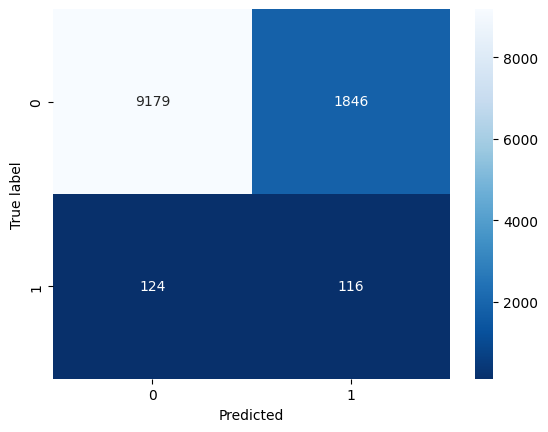

In [243]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

cb_model = CatBoostClassifier(verbose=False,
                              random_state=RANDOM_STATE)

cb_param = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [3, 5, 10],
        'iterations': [100, 300, 500],
        'scale_pos_weight': [0.7 * pos_weight, 0.9 * pos_weight, pos_weight, pos_weight, 1.2 * pos_weight]}

catboost_model = search_best_estimator(cb_model, cb_param, X_train, y_train)
analyze_model(catboost_model, X_test, y_test)

Удалось найти модель, которая совершает меньше ошибок первого рода, но полнота предсказаний снизилась.

## Вывод

При работе над данным проектом мы анализировали данные о покупках пользователей маркетплейса и рекламных рассылках для них. Перед нами стояла задача выделения пользователей, готовых совершить покупку.

Все данные соответствовали описанию. Во время предобработки данных:
- удалили 48 610 дубликатов из messages, потеряли 0.4% данных,
- проанализировали данные и пришли к выводу, что дубликаты в purchases (73 020) могут отражать записи о разных покупках, совершенных в течение одного дня, поэтому их сохранили,
- удалили информацию из messages по клиентам, которых нет в target_binary, итоговый размер составляет 10 913 197 записей (общая потеря составила 14% данных).

Провели исследовательский анализ данных. Выявили наличие ошибочных данных в столбце 'message_id' датасета 'purchases'.

Мы подготовили признаки, основываясь на информации датасетов purchases и messages. Провели корреляционный анализ, убрали признаки, не показавшие корреляцию с таргетом, а также признаки, сильно кореелирующие между собой. Итоговый набор признаков:
- share_of_click
- share_of_open
- share_of_involment
- period_of_interaction
- share_of_phone_msgs
- total_messages
- most_popular_first_category
- days_with_purchases
- days_since_last_purchase
- period_of_activity
- total_cost
- total_purchases

Перед нами стояла задача бинарной классификации, обучение с учителем, дисбаланс классов. Подобрали гиперпараметры для моделей CatBoostClassifier, LGBMClassifier, KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier. Учитывали дисбаланс классов (стратифицировали выборки, использовали гиперпараметры, помогающие в случае дисбаланса, кросс-валидацию).

Лучшая модель по результатам кросс-валидации: CatBoostClassifier с параметрами scale_pos_weight=50.4951, random_state=42,learning_rate=0.03, l2_leaf_reg=1, iterations=300, depth=4. Значение ROC-AUC на тестовой выборке: 0.72.

Самые значимые признаки: days_since_last_purchase, share_of_click, share_of_involment, share_of_phone_msgs, total_purchases, period_of_interaction, total_messages.
Модель успешно обнаружила 57.9% клиентов, которые совершат покупку (139 из 240), но число ошибок первого рода довольно большое. Модель нуждается в улучшении.

Отказавшись от трех самых малозначительных признаков (period_of_activity
total_cost, most_popular_first_category) удалось постриоть модель CatBoostClassifier ('scale_pos_weight': 32.24484679665738, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 4), ROC-AUC на кросс-валидации: 0.745, на тестовой выборке: 0.745. Модель совершает меньше ошибок первого рода, но число верно определенных экземпляров положительного класса снизилось.
